# Machine Learning Project

<details>
<summary><strong>Table of Contents</strong> (Click to expand)</summary>

- [I. Identifying Business Needs](#business-needs)
- [II. Data Exploration and Preprocessing](#data-exploration)
  - [Boolean Features](#boolean-features)
  - [Categorical Features](#categorical-features)
  - [Numerical Features](#numerical-features)
  - [Preprocessing Pipeline](#preprocessing)
- [III. Regression Benchmarking](#benchmarking)
  - [Model Selection Strategy](#model-selection-strategy)
  - [Quick Baseline Model](#quick-baseline-model)
- [IV. Open-Ended Section: Advanced Search](#open-ended)
  - [Experiment Algorithms](#experiment-algorithms)
  - [Final Model Selection](#final-model-selection)
- [V. Deployment](#deployment)

</details>

# Abstract

### Context:
This project addresses car price prediction—a fundamental regression task in machine learning. The dataset includes features spanning categorical attributes (brand, model, transmission type, fuel type) and numerical characteristics (mileage, engine size, tax, MPG, paint quality). This problem is relevant for automotive valuations, insurance pricing, and market analysis.

### Objectives:
The primary goals were to:
1.  Systematically explore and preprocess complex, real-world automotive data containing missing values, outliers, and inconsistencies.
2.  Develop a robust preprocessing pipeline that prevents data leakage through proper fold-wise application.
3.  Benchmark multiple regression algorithms (Linear, Ensemble, Neural Networks) with hyperparameter tuning via cross-validation.
4.  Identify the most influential features through importance analysis.

### Methodology:
Data exploration revealed categorical inconsistencies (typos) and numerical anomalies. The preprocessing pipeline incorporated:
*   **Data Cleaning**: Handling outliers (IQR) and standardizing categorical values (Edit Distance).
*   **Feature Engineering**: Transforming `year` to `age` and log-transforming skewed features like `mileage`.
*   **Encoding**: Using **Target Encoding** for high-cardinality features (`model`) and One-Hot Encoding for others.
*   **Ablation Analysis**: We treated preprocessing steps as hyperparameters, training approximately **720 models** across 8 different algorithms to find the optimal combination of pipeline and model parameters.

### Main Results:
Initial benchmarking with **Ridge Regression** established a baseline and demonstrated that **log-transforming the target variable** is critical for linear models (improving MAE by ~£400). The extensive search revealed that **HistGradientBoostingRegressor** achieved the best performance (**MAE: £1345.14 ± £22.58**). 

The optimal configuration included:
*   **Model Parameters**: `learning_rate` ≈ 0.107, `max_depth`=20, `l2_regularization` ≈ 0.611.
*   **Pipeline Parameters**: `log_target=True`, `standardize_cats_flag=True`, and `feature_selection_k=30`.
*   **Ablation Finding**: The best model opted *not* to remove outliers (`clean_outliers_flag=False`), indicating its robustness to extreme values.

### Conclusions:
The project demonstrates that while preprocessing is essential, the choice of algorithm plays a dominant role. The superior performance of **HistGradientBoostingRegressor** highlights the importance of handling non-linear relationships in pricing data. Our ablation analysis confirmed that while log-transforming the target can be beneficial, advanced ensemble methods could handle outliers effectively without explicit removal. The final model is selected based on rigorous cross-validation to ensure generalizability.

<a id="business-needs"></a>
## I. Identifying Business Needs

### Overview and Goals
The primary objective of this project is to build a robust machine learning model to predict the price of used cars based on their attributes (brand, model, mileage, etc.). Accurate price prediction is essential for:
- **Dealerships**: To set competitive yet profitable prices.
- **Buyers**: To assess fair market value.
- **Insurance Companies**: To estimate vehicle value for premiums and claims.

### Process Description
Our workflow follows a structured data science lifecycle:
1.  **Data Exploration**: Understanding the distribution and quality of the data.
2.  **Preprocessing**: Cleaning data and preparing it for modeling (handling missing values, outliers, encoding).
3.  **Benchmarking**: Establishing a baseline with simple linear models.
4.  **Advanced Search**: Exploring complex algorithms and feature subsets.
5.  **Deployment**: Generating predictions for the test set.

### Assessment Approach
We employ **K-Fold Cross-Validation (K=3)** as our primary assessment strategy.
- **Metric**: Mean Absolute Error (MAE) is used as the primary metric because it is interpretable (average error in £).
- **Validation**: We strictly separate training and validation data within each fold to prevent leakage.

### Computational Constraints & Demo Mode
Given the complexity of the pipeline (preprocessing inside CV loops) and the size of the dataset, a full hyperparameter search is computationally expensive.
- **Full Mode**: Runs 30-50 iterations of random search per algorithm to find the absolute best configuration.
- **Demo Mode**: skips the most expensive models (like Random Forest) to allow for quick pipeline verification.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import loguniform, randint

# Import custom utility functions
from model_training_utils import (
    general_cleaning, 
    preprocess_data,
    get_feature_importance,
    cross_validate_with_tuning,
    preprocess_test_data
)

# Set random seed for reproducibility
SEED = 123
np.random.seed(SEED)

# Configuration
DEMO_MODE = False # Set to True to run a quick demo with fewer iterations

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/train.csv').set_index('carID')
df.head()

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


In [4]:
# 1. General Cleaning
df_cleaned = general_cleaning(df)

# Separate features and target
X = df_cleaned.drop(columns=['price'])
y = df_cleaned['price']

print(f"Cleaned dataset shape: {df_cleaned.shape}")
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Cleaned dataset shape: (75973, 13)
Features shape: (75973, 12), Target shape: (75973,)


<a id="import-data-summary"></a>
#### Import Data Summary
- Dataset loaded successfully with `carID` as the index
- There are no duplicate entries in carID
- The dataset contains information about cars including both numerical features (price, mileage, tax, etc.) and categorical features (brand, model, transmission, etc.)
- Initial inspection shows multiple features that will require preprocessing:
  - Numerical features that need cleaning (negative values, outliers)
  - Categorical features that need standardization
  - Presence of missing values in several columns

<a id="data-exploration"></a>
## II. Data Exploration and Preprocessing

<a id="boolean-features"></a>
### Boolean Features

In [5]:
df['hasDamage'].value_counts(dropna=False)

hasDamage
0.0    74425
NaN     1548
Name: count, dtype: int64

<a id="boolean-features-analysis"></a>
#### Boolean Features Analysis

Key observations about `hasDamage` feature:
- Only contains binary values (0) and NaN
- No instances of value 1 found, suggesting potential data collection issues
- May indicate:
  - Cars with damage not being listed
  - System default setting of 0 for non-damaged cars
  - Incomplete damage assessment process
- Requires special handling in preprocessing:
  - Consider treating NaN as a separate category
  - Validate if 0 truly represents "no damage"
  - May need to be treated as a categorical rather than boolean feature

<a id="categorical-features"></a>
### Categorical Features

<a id="check-categorical-features-consistency"></a>
#### Check Categorical Features Consistency

In [6]:
# List of categorical features
cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

# Identify outlier examples in categorical features
cat_outliers_examples = {col: df[col].value_counts().tail(10).index for col in cat_cols}

# Display the outlier examples
pd.DataFrame(cat_outliers_examples)

,Brand,model,fuelType,transmission
0,mercede,GOLF SV,Othe,utomati
1,kod,tiguan,ther,manual
2,AUD,CLK,Electric,AUTOMATI
3,KODA,gtc,YBRID,emi-Aut
4,HYUNDA,Gol,OTHER,Other
5,OYOTA,M5,other,semi-aut
6,SKOD,gls class,HYBRI,manua
7,TOYOT,Mokka,ybri,UTOMATIC
8,skod,6 Serie,ETRO,manual
9,toyot,JETTA,IESE,nknow


<a id="categorical-features-summary"></a>
#### Categorical Features Summary
- Initial analysis reveals significant data quality issues across all categorical columns
- No standardization in categorical features, with multiple variations of the same values (different spellings, capitalizations)
- Solution: We will implement string distance-based standardization using the `nltk` library to clean and standardize these features

<a id="numerical-features"></a>
### Numerical Features

In [7]:
# Dict of numerical features
num_cols = {
    'price': 'continuous',
    'mileage': 'continuous',
    'tax': 'continuous',
    'mpg': 'continuous',
    'paintQuality%': 'continuous',
    'engineSize': 'continuous',
    'year': 'discrete',
    'previousOwners': 'discrete'
}

<a id="plots"></a>
#### Numerical Plots

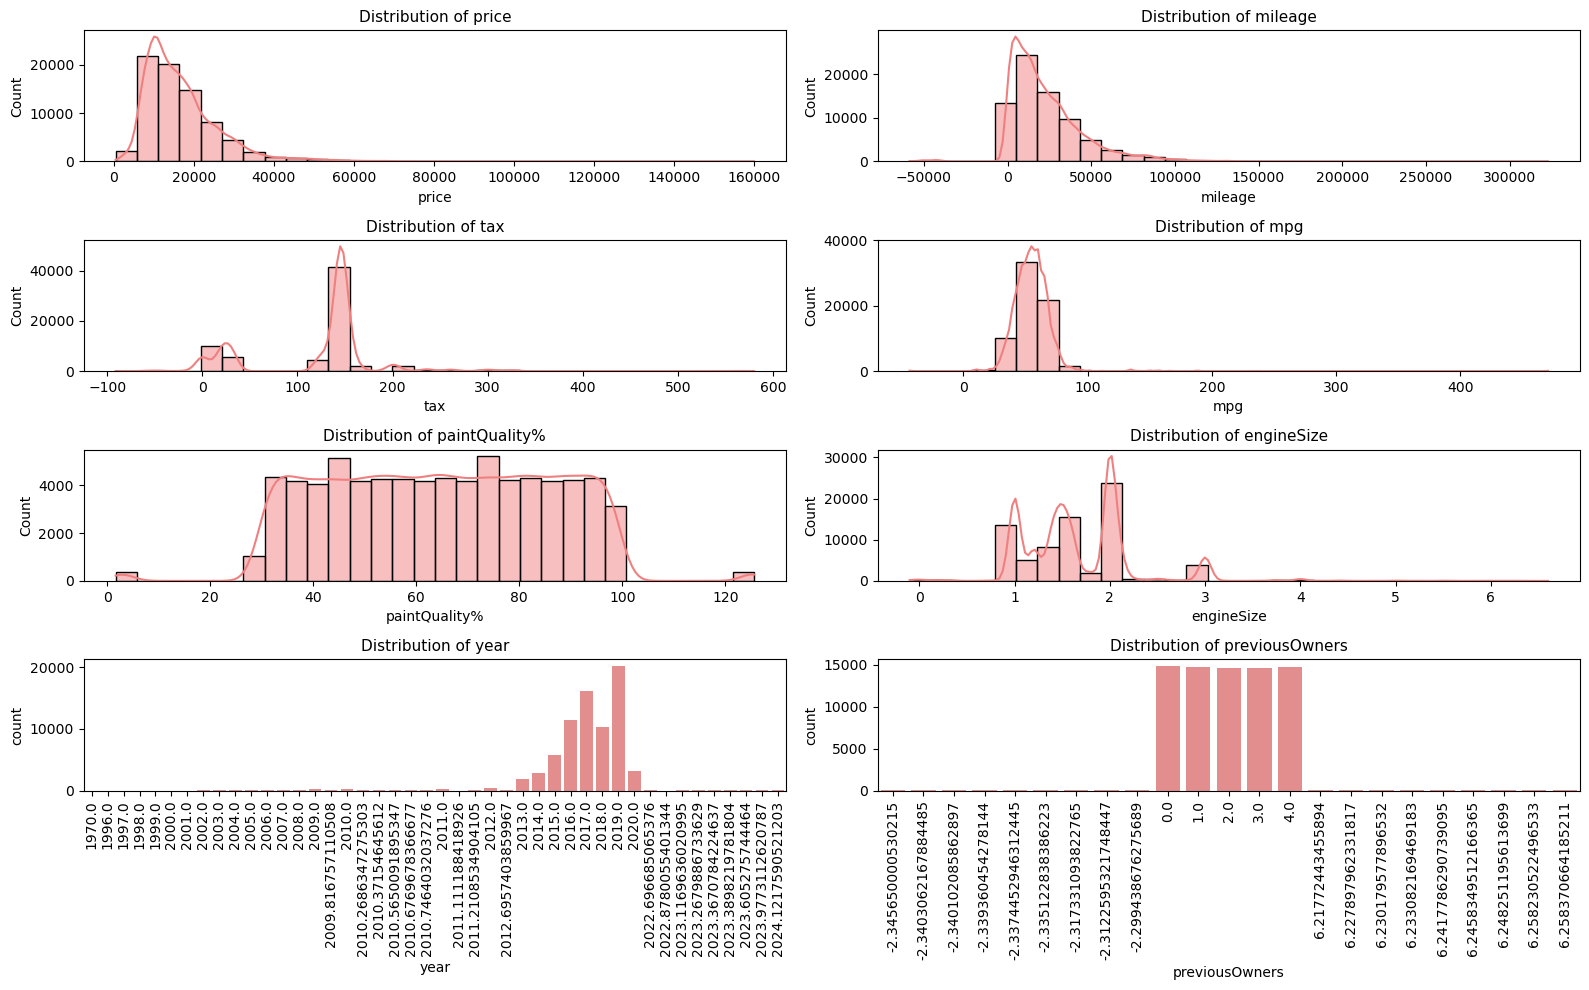

In [8]:
# Plot figures for numerical features and the target variable (price)
plt.figure(figsize=(16, 10))
for i, (col, var_type) in enumerate(num_cols.items(), 1):
    plt.subplot(4, 2, i)

    # Plot based on variable type
    if var_type == 'continuous':
        sns.histplot(data=df, x=col, kde=True, color="lightcoral", bins=30)
        plt.title(f"Distribution of {col}", fontsize=11)
    elif var_type == 'discrete':
        sns.countplot(data=df, x=col, color="lightcoral")
        plt.title(f"Distribution of {col}", fontsize=11)
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

The dataset is dominated by lower-priced, lower-mileage vehicles, with long right tails for both price and mileage indicating a small number of high-value and high-usage cars. Tax and engine size show multi-modal distributions, reflecting different vehicle categories and regulations. Year and previous owners present discrete, concentrated patterns consistent with typical used-car inventories.

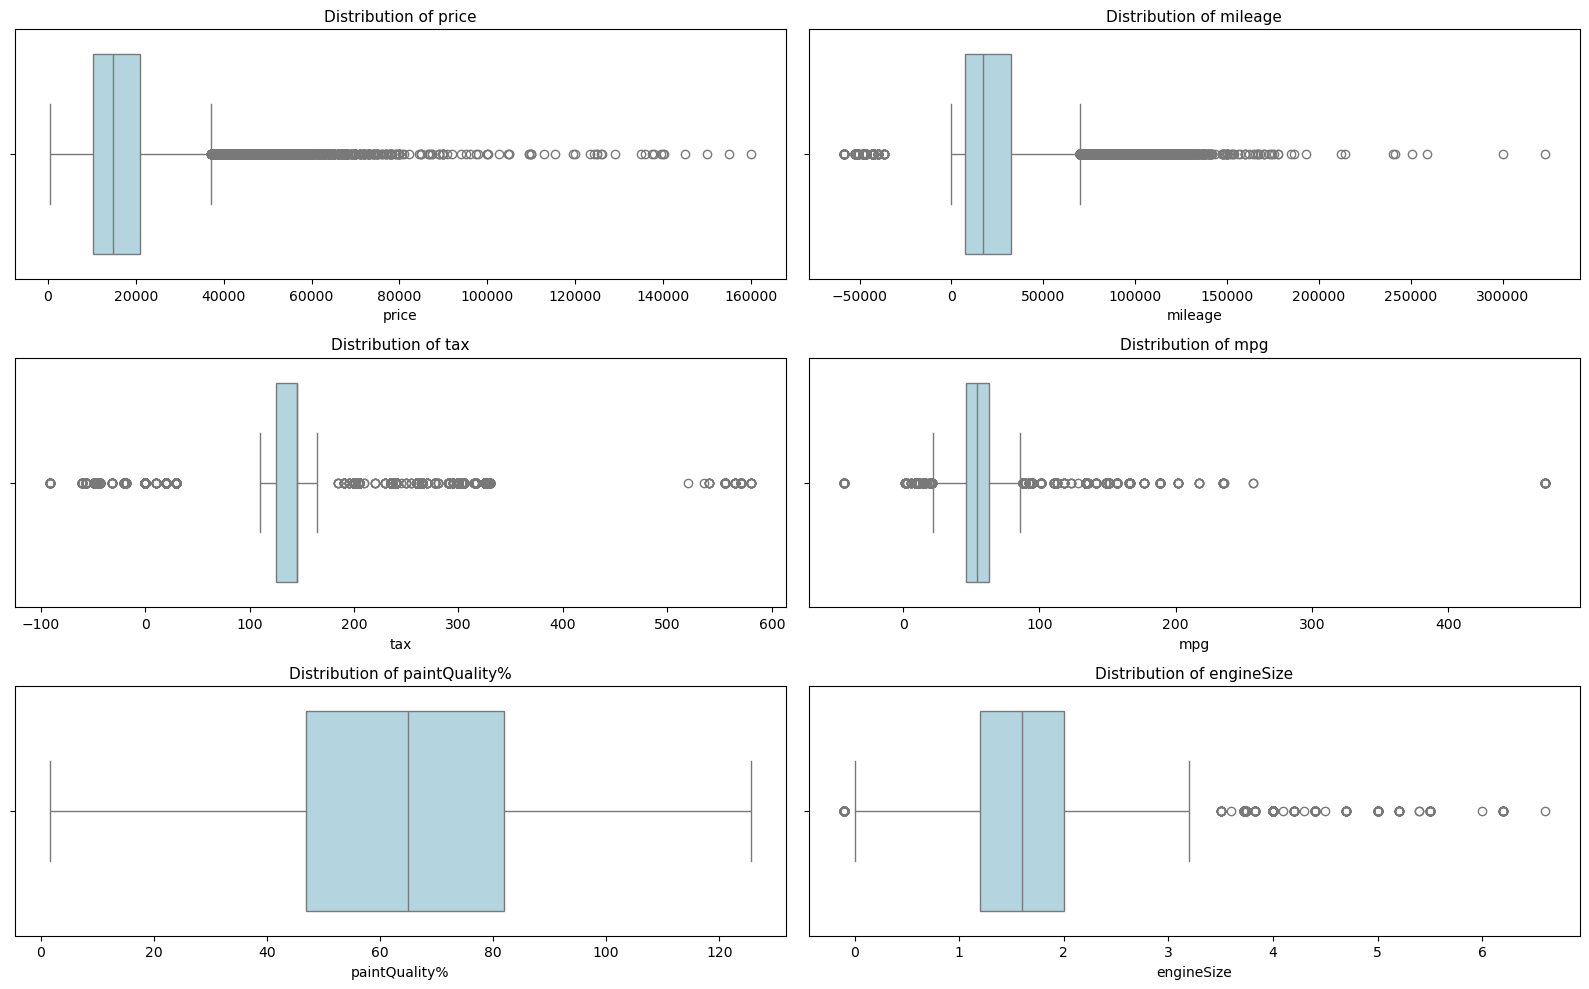

In [9]:
# Boxplots for continuous numerical features and the target variable (price)
continuous_cols = [col for col, var_type in num_cols.items() if var_type == 'continuous']
plt.figure(figsize=(16, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, color="lightblue")
    plt.title(f"Distribution of {col}", fontsize=11)

plt.tight_layout()
plt.show()

The boxplots confirm strong right tails and many extreme values for price and mileage. Tax and mpg also contain multiple outliers, including unusual low/negative tax values and very high mpg values. paintQuality% spans a wide range (including values above 100), while engineSize is mostly concentrated around common sizes with a few very large outliers.

<a id="analysis-of-numerical-distributions"></a>
#### Analysis of Numerical Distributions

Key observations from the plots:
- **Target Variable (Price)**:
  - Highly right-skewed distribution
  - Contains significant number of outliers in the upper range
  - Most cars are concentrated in the lower price range

- **Mileage**:
  - Right-skewed distribution. **Action**: We will apply a log-transformation to linearize this relationship with price.
  - Large range from nearly new cars to high-mileage vehicles
  - Some outliers in upper range suggesting possible data entry errors

- **Tax**:
  - Multiple peaks suggesting different tax bands
  - Contains negative values which require investigation (possible tax benefits/rebates)
  - Large number of outliers on both ends of the distribution

- **MPG (Miles Per Gallon)**:
  - Approximately normal distribution with slight right skew
  - Some unrealistic extreme values that need cleaning
  - Reasonable median around typical car efficiency ranges

- **Paint Quality %**:
  - Contains values above 100% which are logically impossible
  - Left-skewed distribution suggesting optimistic ratings
  - Requires standardization to 0-100 range

- **Engine Size**:
  - There are engine size with zero values which are not realistic (might indicate electric vehicles)
  - Some unusual patterns that need investigation
  - Contains outliers that may represent specialty vehicles

- **Year**:
  - Should be discrete but contains decimal values

- **Previous Owners**:
  - Should be integer but contains float values
  - Right-skewed distribution as expected
  - Maximum values need validation (unusually high number of previous owners)

<a id="preprocessing"></a>
### Preprocessing Pipeline

<a id="preprocessing-pipeline-summary"></a>
## Summary of Preprocessing Pipeline

We have implemented a comprehensive preprocessing pipeline (`preprocess_data`) that handles the specific characteristics of this dataset:

1.  **Feature Engineering & Transformations**:
    *   **Log Transformation**: Applied to `mileage` to handle its heavy right-skew.
    *   **Age Calculation**: Converted `year` to `age` (2020 - year) to capture depreciation.

2.  **Categorical Encoding**:
    *   **Target Encoding**: Applied to the `model` feature. Since `model` has high cardinality (many unique values), One-Hot Encoding would create too many sparse features. Target Encoding maps each car model to the average price of that model (smoothed), capturing the signal efficiently.
    *   **One-Hot Encoding**: Applied to low-cardinality features (`Brand`, `transmission`, `fuelType`).

3.  **Data Cleaning**:
    *   **Outlier Removal**: Uses the IQR method (tunable via `clean_outliers_flag`).
    *   **Imputation**: Missing values are filled with medians from the training set.
    *   **Standardization**: Numerical features are scaled using `StandardScaler` (`normalize_flag`).

4.  **Leakage Prevention**:
    *   All statistics (medians, target encoding maps, scalers) are learned *only* on the training split and applied to validation/test data.

<a id="data-preparation"></a>
### Data Preparation

In [10]:
# Prepare cleaned data for cross-validation
df_cleaned = general_cleaning(df)
X = df_cleaned.drop(columns=["price"])
y = df_cleaned["price"]

# Remove 'price' from num_cols since it's the target
del num_cols['price']

print(f"Dataset size: {X.shape}")
print(f"Target range: £{y.min():.2f} - £{y.max():.2f}")


Dataset size: (75973, 12)
Target range: £450.00 - £159999.00


<a id="correlation-analysis"></a>
#### Correlation Analysis

Before model training, let's examine correlations between numerical features to understand their relationships.

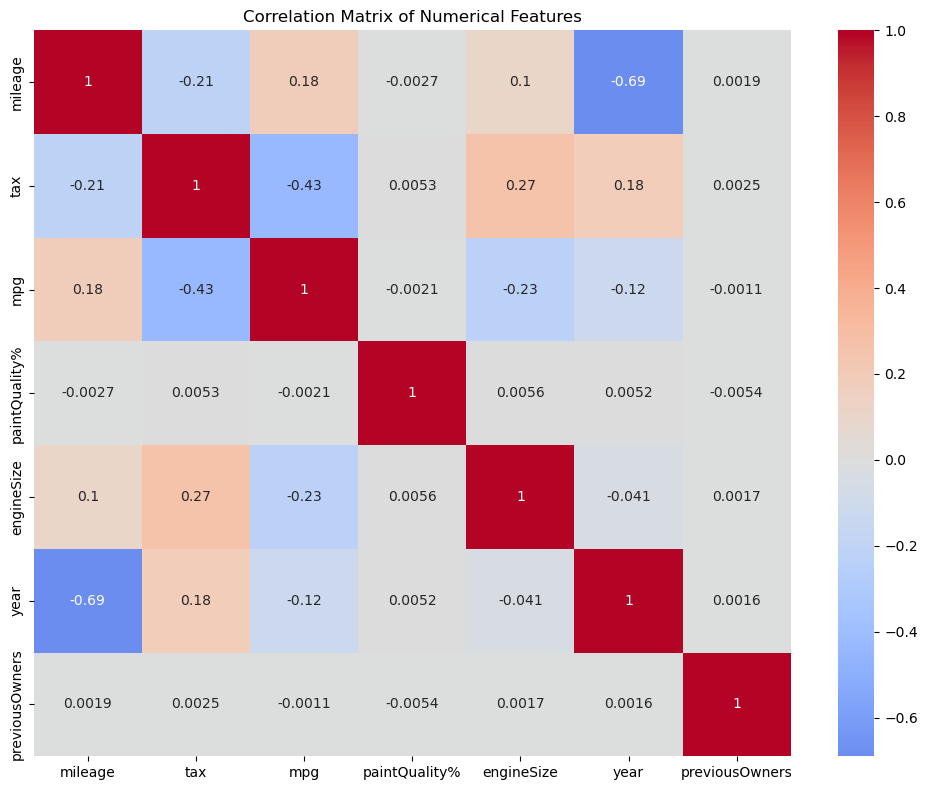

In [11]:
# Correlation matrix for numerical features
fig = plt.figure(figsize=(10, 8))
corr = X[list(num_cols.keys())].corr(method="pearson")
sns.heatmap(data=corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

The correlation matrix shows mostly weak linear relationships among numerical features, with the strongest associations observed between year and mileage (strong negative correlation) and between tax and mpg (moderate negative correlation). Other variables, such as paintQuality% and previousOwners, exhibit near-zero correlations with the remaining features.

<a id="benchmarking"></a>
## III. Regression Benchmarking


<a id="model-selection-strategy"></a>
### Model Selection Strategy

We employ a robust **Cross-Validation (CV)** strategy with **Randomized Hyperparameter Search** to select the best model.

#### 1. Prevention of Data Leakage
A critical aspect of our pipeline is that **preprocessing occurs inside the cross-validation loop**.
- For every fold, statistics (medians, outlier bounds, categorical frequencies) are calculated *only* on the training portion.
- These statistics are then applied to the validation portion.
- This ensures that the validation score is a true estimate of performance on unseen data, as no information from the validation set leaks into the training process.

#### 2. Dynamic Feature Selection
We treat feature selection as a hyperparameter. Using `SelectKBest` with `f_regression`, we dynamically select the top $k$ features during training.
- The parameter `feature_selection_k` controls how many features are kept.
- By including this in the search space (e.g., `[10, 20, 30, None]`), the model can "choose" whether to use a subset of informative features or the full feature set.

#### 3. Tunable Pipeline Parameters
Beyond model-specific hyperparameters (like `alpha` for Ridge or `n_estimators` for Random Forest), we tune the preprocessing pipeline itself:
- **`clean_outliers_flag`**: (True/False) Whether to remove outliers from numerical features using the IQR method.
- **`standardize_cats_flag`**: (True/False) Whether to fix typos in categorical variables using edit distance.
- **`normalize_flag`**: (True/False) Whether to scale numerical features (StandardScaler).
- **`log_target`**: (True/False) Whether to train on $log(1 + price)$.
    *   **Rationale**: The price distribution is highly right-skewed. Training on the raw scale causes models to over-penalize errors on expensive cars. Log-transforming the target makes the distribution more normal, stabilizing the variance and typically improving performance (MAE).

#### 4. Configuration Structure
Each experiment is defined by a configuration dictionary. Here is an example of how we define the search space:

```python
config = {
    'model_class': RandomForestRegressor,
    'param_distributions': {
        # Model-specific parameters
        'n_estimators': randint(100, 300),
        'max_depth': [None, 10, 20],
        
        # Pipeline parameters
        'clean_outliers_flag': [True, False],
        'standardize_cats_flag': [True, False],
        'log_target': [True, False],
        
        # Feature selection parameter
        'feature_selection_k': [10, 20, 30, None] 
    },
    'n_iter': 20  # Number of random combinations to try
}
```

<a id="quick-baseline-model"></a>
### Quick Baseline Model

Before running extensive CV, we train a simple **Ridge Regression** model to establish a baseline and verify the impact of log-transforming the target.

**Conclusion**: The log-transformation of the target variable improves the Mean Absolute Error by nearly **£400**. This confirms that handling the skewness of the price variable is critical for this dataset. We will prioritize `log_target=True` in our advanced search but will keep it as a tunable parameter to be sure.

In [12]:
# Quick train/val split for baseline
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Preprocess baseline data 
X_train_processed, baseline_artifacts = preprocess_data(X_train_baseline, cat_cols, num_cols, fit=True, y=y_train_baseline)
X_val_processed = preprocess_data(X_val_baseline, cat_cols, num_cols, artifacts=baseline_artifacts, fit=False) 

# 1. Baseline WITH Log Transform 
baseline_model_log = Ridge(alpha=1.0, fit_intercept=True)
baseline_model_log.fit(X_train_processed, np.log1p(y_train_baseline))

y_train_pred_log = np.expm1(baseline_model_log.predict(X_train_processed))
y_val_pred_log = np.expm1(baseline_model_log.predict(X_val_processed))

mae_train_log = mean_absolute_error(y_train_baseline, y_train_pred_log)
mae_val_log = mean_absolute_error(y_val_baseline, y_val_pred_log)
r2_val_log = r2_score(y_val_baseline, y_val_pred_log)

print(f"Baseline Ridge (WITH Log Transform):")
print(f"  Train MAE: £{mae_train_log:.2f}")
print(f"  Val MAE:   £{mae_val_log:.2f}")
print(f"  Val R²:    {r2_val_log:.4f}")

# 2. Baseline WITHOUT Log Transform
baseline_model_no_log = Ridge(alpha=1.0, fit_intercept=True)
baseline_model_no_log.fit(X_train_processed, y_train_baseline)

y_train_pred_no_log = baseline_model_no_log.predict(X_train_processed)
y_val_pred_no_log = baseline_model_no_log.predict(X_val_processed)

mae_train_no_log = mean_absolute_error(y_train_baseline, y_train_pred_no_log)
mae_val_no_log = mean_absolute_error(y_val_baseline, y_val_pred_no_log)
r2_val_no_log = r2_score(y_val_baseline, y_val_pred_no_log)

print(f"\nBaseline Ridge (WITHOUT Log Transform):")
print(f"  Train MAE: £{mae_train_no_log:.2f}")
print(f"  Val MAE:   £{mae_val_no_log:.2f}")
print(f"  Val R²:    {r2_val_no_log:.4f}")

Baseline Ridge (WITH Log Transform):
  Train MAE: £2351.23
  Val MAE:   £2336.34
  Val R²:    0.8296

Baseline Ridge (WITHOUT Log Transform):
  Train MAE: £2720.63
  Val MAE:   £2691.89
  Val R²:    0.8040


<a id="open-ended"></a>
## IV. Open-Ended Section: Advanced Search & Ablation Analysis

### Objectives
In this section, we go beyond standard benchmarking by conducting a comprehensive **Ablation Analysis** integrated directly into our hyperparameter search. Our goal is to determine not just the best *algorithm*, but the optimal *preprocessing strategy* for each algorithm.

### Methodology: Pipeline as a Hyperparameter
Instead of fixing the preprocessing steps beforehand, we treat key preprocessing decisions as **tunable hyperparameters**. This allows us to perform an automated ablation study during Cross-Validation.

For every model iteration, the randomized search selects:
1.  **Preprocessing Flags** (Ablation):
    *   `clean_outliers_flag`: Does removing outliers improve performance?
    *   `standardize_cats_flag`: Does fixing typos in categorical data help?
    *   `log_target`: Is log-transforming the price beneficial for this specific model?
    *   `normalize_flag`: Does scaling features matter for tree-based models vs. linear models?
2.  **Feature Subset** (Dynamic Selection):
    *   `feature_selection_k`: How many top features ($k$) yield the best results?
3.  **Model Hyperparameters**:
    *   Standard algorithm-specific parameters (e.g., `n_estimators`, `alpha`).

### Actions Taken
We expand our search to include advanced algorithms—**Random Forest, Gradient Boosting, Extra Trees, and MLP**—while simultaneously optimizing the pipeline configuration for each.

### Discussion of Findings
The results below will reveal the optimal combination of **Algorithm + Preprocessing Strategy + Feature Subset**. This approach allows us to scientifically validate whether specific preprocessing steps (like outlier removal) actually contribute to model performance or if they are unnecessary for robust non-linear models like Random Forest.

<a id="experiment-algorithms"></a>
### Experiment Algorithms

In [13]:
# Example 0: Linear Regression
lr_config = {
    'model_class': LinearRegression,
    'param_distributions': {
        'fit_intercept': [True, False],
        'clean_outliers_flag': [True, False],
        'standardize_cats_flag': [True, False],
        'normalize_flag': [True, False],
        'log_target': [True, False],
        'feature_selection_k': [10, 20, 30, 40, 50, None]
    },
    'n_iter': 10
}

lr_results = cross_validate_with_tuning(
    X, 
    y, 
    cat_cols, 
    num_cols, 
    lr_config, 
    k=3, 
    seed=SEED
)

Starting 3-Fold CV with LinearRegression (10 hyperparam combinations)...

Refitting best model on all available data...
Fitted 30 models in total.
Features Selected: 50

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  fit_intercept  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k
    2427.2454       9.1585           True                False                   True            True        True                   50
    2431.2433       8.5545           True                False                   True            True        True                   30
    2450.2392       6.0434           True                False                   True           False        True                   20
    2450.3772       6.1613           True                False                   True           False        True                   20
    2655.2334      16.8128           True                False                  False            True       False       

In [14]:
# Example 1: Ridge Regression with hyperparameter tuning
ridge_config = {
    'model_class': Ridge,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False],
        'clean_outliers_flag': [True, False],
        'standardize_cats_flag': [True, False],
        'normalize_flag': [True, False],
        'log_target': [True, False],
        'feature_selection_k': [10, 20, 30, 40, 50, None]
    },
    'n_iter': 30
}

ridge_results = cross_validate_with_tuning(
    X, 
    y, 
    cat_cols, 
    num_cols, 
    ridge_config, 
    k=3, 
    seed=SEED
)

Starting 3-Fold CV with Ridge (30 hyperparam combinations)...

Refitting best model on all available data...
Fitted 90 models in total.
Features Selected: 50

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae   alpha  fit_intercept  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k
    2337.4676       7.6437 34.9076           True                 True                  False            True        True                 50.0
    2404.2674       8.1737  5.5810           True                False                  False           False        True                 50.0
    2411.0999       2.0225  0.7534           True                False                  False           False        True                 40.0
    2427.4029       9.2149  0.4161           True                False                   True            True        True                 50.0
    2428.6964       8.8908  0.0682           True                False                   Tr

In [15]:
# Example 2: Lasso Regression
lasso_config = {
    'model_class': Lasso,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False],
        'clean_outliers_flag': [True, False],
        'standardize_cats_flag': [True, False],
        'normalize_flag': [True, False],
        'log_target': [True, False],
        'feature_selection_k': [10, 20, 30, 40, 50, None],
        'max_iter': 10000 # Increased from default 1000 to prevent convergence warnings
    },
    'n_iter': 30
}

lasso_results = cross_validate_with_tuning(
    X, 
    y, 
    cat_cols, 
    num_cols, 
    lasso_config, 
    k=3, 
    seed=SEED
)

Starting 3-Fold CV with Lasso (30 hyperparam combinations)...

Refitting best model on all available data...
Fitted 90 models in total.
Features Selected: 76

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae   alpha  fit_intercept  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k  max_iter
    2635.2866      15.4836 11.4030           True                 True                  False           False       False                  NaN     10000
    2655.1852      17.2713  0.0034           True                False                  False            True       False                 20.0     10000
    2705.5034      15.1938  8.0264           True                 True                  False            True       False                 10.0     10000
    2734.2126      28.3566  2.0260           True                 True                   True            True       False                 40.0     10000
    2734.3462      27.5191  0.0058       

In [16]:
# Example 3: Random Forest
rf_results = None

if not DEMO_MODE:
    rf_config = {
        'model_class': RandomForestRegressor,
        'param_distributions': {
            'n_estimators': randint(100, 300),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 0.5, 0.75, 1.0],
            'n_jobs': [-1],
            'random_state': SEED,
            'clean_outliers_flag': [True, False],
            'standardize_cats_flag': [True, False],
            'normalize_flag': [True, False],
            'log_target': [True, False],
            'feature_selection_k': [10, 20, 30, 40, 50, None] # Try selecting top K features
        },
        'n_iter': 40
    }

    rf_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        rf_config, 
        k=3, 
        seed=SEED
    )
else:
    print("Skipping Random Forest in Demo Mode")

Starting 3-Fold CV with RandomForestRegressor (40 hyperparam combinations)...

Refitting best model on all available data...
Fitted 120 models in total.
Features Selected: 40

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  n_jobs  random_state  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k
    1373.7355       8.0054           197       20.0                  3                 2         0.75      -1           123                 True                  False            True        True                 40.0
    1388.6081      10.4972           261       30.0                  3                 2          0.5      -1           123                 True                   True            True        True                  NaN
    1416.2633      11.9387           287        NaN                 13                 3          0.5      -1           123               

In [17]:
# Example 4: Hist Gradient Boosting Regressor
hgb_results = None

if not DEMO_MODE:
    hgb_config = {
        'model_class': HistGradientBoostingRegressor,
        'param_distributions': {
            'learning_rate': loguniform(0.01, 0.3),
            'max_depth': [None, 10, 20, 30],
            'max_leaf_nodes': randint(15, 63),
            'l2_regularization': loguniform(1e-3, 10),
            'max_iter': 1000,
            'early_stopping': True,
            'loss': ['absolute_error'],
            'random_state': SEED,
            'clean_outliers_flag': [True, False],
            'standardize_cats_flag': [True, False],
            'normalize_flag': [True, False],
            'log_target': [True, False],
            'feature_selection_k': [10, 20, 30, 40, 50, None]
        },
        'n_iter': 40
    }

    hgb_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        hgb_config, 
        k=3, 
        seed=SEED
    )
else:
    print("Skipping Hist Gradient Boosting in Demo Mode")

Starting 3-Fold CV with HistGradientBoostingRegressor (40 hyperparam combinations)...

Refitting best model on all available data...
Fitted 120 models in total.
Features Selected: 30

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  learning_rate  max_depth  max_leaf_nodes  l2_regularization  max_iter  early_stopping           loss  random_state  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k
    1345.1424      22.5822         0.1068       20.0              60             0.6108      1000            True absolute_error           123                False                   True            True        True                 30.0
    1364.2367      10.5363         0.0708        NaN              34             0.2003      1000            True absolute_error           123                False                  False           False        True                 40.0
    1367.3277      11.8009         0.2150       10.0              36     

In [18]:
# Example 5: Gradient Boosting Regressor (Standard)
gb_results = None

if not DEMO_MODE:
    gb_config = {
        'model_class': GradientBoostingRegressor,
        'param_distributions': {
            'n_estimators': randint(50, 200),
            'learning_rate': loguniform(0.01, 0.3),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'subsample': [0.8, 0.9, 1.0],
            'random_state': SEED,
            'n_iter_no_change': [10],
            'clean_outliers_flag': [True, False],
            'standardize_cats_flag': [True, False],
            'normalize_flag': [True, False],
            'log_target': [True, False],
            'feature_selection_k': [10, 20, 30, 40, 50, None]
        },
        'n_iter': 40
    }

    gb_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        gb_config, 
        k=3, 
        seed=SEED
    )
else:
    print("Skipping Gradient Boosting in Demo Mode")

Starting 3-Fold CV with GradientBoostingRegressor (40 hyperparam combinations)...

Refitting best model on all available data...
Fitted 120 models in total.
Features Selected: 20

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  learning_rate  max_depth  min_samples_split  min_samples_leaf  subsample  random_state  n_iter_no_change  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k
    1372.8157       5.8756           145         0.0696       30.0                  9                 8        0.9           123                10                False                   True            True        True                 20.0
    1383.6831       8.2004           110         0.0594        NaN                 11                 3        0.8           123                10                False                  False           False        True                 50.0
    1390.6833      11.5355           133         0.0708       30.

In [19]:
# Example 6: Extra Trees Regressor
et_results = None

if not DEMO_MODE:
    et_config = {
        'model_class': ExtraTreesRegressor,
        'param_distributions': {
            'n_estimators': randint(100, 300),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 0.5, 0.75, 1],
            'n_jobs': [-1],
            'random_state': SEED,
            'clean_outliers_flag': [True, False],
            'standardize_cats_flag': [True, False],
            'normalize_flag': [True, False],
            'log_target': [True, False],
            'feature_selection_k': [10, 20, 30, 40, 50, None]
        },
        'n_iter': 40
    }

    et_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        et_config, 
        k=3, 
        seed=SEED
    )
else:
    print("Skipping Extra Trees in Demo Mode")

Starting 3-Fold CV with ExtraTreesRegressor (40 hyperparam combinations)...

Refitting best model on all available data...
Fitted 120 models in total.
Features Selected: 40

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  n_jobs  random_state  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k
    1391.9193       8.2717           197       20.0                  3                 2         0.75      -1           123                 True                  False            True        True                 40.0
    1414.3109       9.6074           261       30.0                  3                 2          0.5      -1           123                 True                   True            True        True                  NaN
    1436.6066      14.7034           138       30.0                  5                 4         0.75      -1           123                 

In [20]:
# Example 7: MLP Regressor (Neural Network)
mlp_results = None

if not DEMO_MODE:
    mlp_config = {
        'model_class': MLPRegressor,
        'param_distributions': {
            'hidden_layer_sizes': [(32,), (64,), (100,), (32, 16), (64, 32), (100, 50)],
            'activation': ['relu', 'tanh'],
            'solver': 'adam',
            'alpha': loguniform(1e-5, 1e-1),
            'learning_rate_init': loguniform(1e-4, 1e-2),
            'max_iter': 2000,
            'early_stopping': True,
            'random_state': SEED,
            'clean_outliers_flag': [True, False],
            'standardize_cats_flag': [True, False],
            'normalize_flag': [True, False],
            'log_target': [True, False],
            'feature_selection_k': [10, 20, 30, 40, 50, None]
        },
        'n_iter': 10
    }

    mlp_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        mlp_config, 
        k=3, 
        seed=SEED
    )
else:
    print("Skipping MLP in Demo Mode")

Starting 3-Fold CV with MLPRegressor (10 hyperparam combinations)...

Refitting best model on all available data...
Fitted 30 models in total.
Features Selected: 30

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae hidden_layer_sizes activation solver  alpha  learning_rate_init  max_iter  early_stopping  random_state  clean_outliers_flag  standardize_cats_flag  normalize_flag  log_target  feature_selection_k
    1727.3266       3.7680           (64, 32)       tanh   adam 0.0012              0.0011      2000            True           123                False                  False            True        True                 30.0
    1807.5436      17.6852          (100, 50)       relu   adam 0.0040              0.0020      2000            True           123                False                   True            True        True                  NaN
    1819.7567      25.4852          (100, 50)       relu   adam 0.0061              0.0025      2000            True           

<a id="final-model-selection"></a>
### Final Model Selection

After evaluating all algorithms, we select the best performing model based on the **Mean Absolute Error (MAE)** from cross-validation.

Once the best model class and its optimal hyperparameters (including preprocessing flags) are identified, we perform a **final refit**:
1.  We take the **entire training dataset** (no train/val split).
2.  We apply the optimal preprocessing pipeline (learning medians, encoders, etc., from the full data).
3.  We train the model on this fully processed dataset.

This ensures the model learns from the maximum amount of available data before making predictions on the test set.

In [ ]:
# Compare all models to find the best one
results = {
    'Linear Regression': lr_results,
    'Ridge': ridge_results,
    'Lasso': lasso_results,
    'Random Forest': rf_results,
    'Hist Gradient Boosting': hgb_results,
    'Gradient Boosting': gb_results,
    'Extra Trees': et_results,
    'MLP': mlp_results,
}

# Filter out None results
results = {k: v for k, v in results.items() if v is not None}

# Select the best model based on the lowest mean CV score (MAE)
best_model_name = min(results, key=lambda k: results[k]['mean_cv_score'])
best_result = results[best_model_name]

print(f"Best Model Selected: {best_model_name}")
print(f"Best CV MAE: £{best_result['mean_cv_score']:.2f} ± £{best_result['std_cv_score']:.2f}")
print(f"Best Parameters: {best_result['best_params']}\n")

# The function now returns the model already fitted on ALL available data
# and the corresponding preprocessing artifacts
best_model = best_result['best_estimator']
final_artifacts = best_result['final_artifacts']

print(f"Final model ({best_model_name}) is ready and fitted on all data.")

# Visualize Feature Importance (if applicable)
try:
    # We need the processed feature names for the plot
    # IMPORTANT: Must use the same preprocessing flags as the best model
    preprocessing_params = final_artifacts.get('preprocessing_params', {})
    
    X_all_processed = preprocess_data(
        X, 
        cat_cols, 
        num_cols, 
        artifacts=final_artifacts, 
        fit=False,
        **preprocessing_params
    )
    
    # Filter selected features if they were used during training
    if 'selected_features' in final_artifacts:
        X_all_processed = X_all_processed[final_artifacts['selected_features']]
        
    get_feature_importance(best_model, X_all_processed, model_class=type(best_model))
except Exception as e:
    print(f"Could not plot feature importance: {e}")

Best Model Selected: Hist Gradient Boosting
Best CV MAE: £1345.14 ± £22.58
Best Parameters: {'learning_rate': 0.10684874790620232, 'max_depth': 20, 'max_leaf_nodes': 60, 'l2_regularization': 0.6107686573608484, 'max_iter': 1000, 'early_stopping': True, 'loss': 'absolute_error', 'random_state': 123, 'clean_outliers_flag': False, 'standardize_cats_flag': True, 'normalize_flag': True, 'log_target': True, 'feature_selection_k': 30}

Final model (Hist Gradient Boosting) is ready and fitted on all data.
Could not plot feature importance: Model HistGradientBoostingRegressor not supported or has no extractable importance.


<a id="deployment"></a>
## V. Deployment

We use the final refitted model to generate predictions for the test dataset.

**Process:**
1.  **Load Test Data**: Read the `test.csv` file.
2.  **Apply Preprocessing**: We use the **artifacts** (medians, outlier bounds, encoders, scaler) learned from the *full training set* to preprocess the test data. This ensures the test features are transformed exactly the same way as the training features.
3.  **Predict**:
    *   If the model was trained on log-transformed targets (`log_target=True`), we predict the log-price and then apply `np.expm1` to convert it back to the original currency scale.
    *   Otherwise, we use the raw predictions.
4.  **Save**: The results are saved to `data/test_predictions.csv`.

In [22]:
# Load and preprocess test data
test_df = pd.read_csv('data/test.csv').set_index('carID')

# Use the artifacts from the final fit on all data
test_processed = preprocess_test_data(test_df, final_artifacts)

# Make predictions
if final_artifacts.get('log_target', True):
    test_predictions = np.expm1(best_model.predict(test_processed))
else:
    test_predictions = best_model.predict(test_processed)

# Save predictions
predictions_df = pd.DataFrame({'price': test_predictions}, index=test_df.index)
predictions_df.to_csv('data/test_predictions.csv')

print(f"Predictions saved for {len(test_predictions)} test samples")
print(f"Predicted price range: £{test_predictions.min():.2f} - £{test_predictions.max():.2f}")

Predictions saved for 32567 test samples
Predicted price range: £1163.96 - £137273.04
